In [317]:
"""
import modules
"""

from prepare_data import prepare_df_from_mac_5_year as prepare_CCL
from prepare_data import prepare_paths as prepare_paths
from emulate_reduction import emulator_v5 as emulate
from visualize_output import vis_emulator_v1 as v1_plot
from pym import pym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

dir(prepare_paths)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'colors',
 'combine_azure_ctax',
 'np',
 'os',
 'output_costs_timer',
 'pd',
 'plot_MAC',
 'plt',
 'prepare_data',
 'pym',
 'truncate_colormap',
 'world_MAC_data']

In [3]:
"""
load data (cubic cubicroot linear and IAMC)
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
PATH_IAMC = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths/'
PATH_IAMC_MYM = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_mym/'
PATH_IAMC_CSV = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_csv/'

FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'
FILENAME_IAMC = 'iamc15_scenario_data_world_r2.0.xlsx'
FILENAME_MEAN_TEMP = 'mean_temp.csv'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

# new paths, from IAMC databese
IAMC_database = pd.read_excel(PATH_IAMC + FILENAME_IAMC, sheet_name='data')

In [593]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2060
region = 2
TIMERSTEP = 10
test_size = 0.2
stepsize_ctax_paths = 10
number_of_weights = 2

['2020' '2030' '2040' '2050' '2060' '2070' '2080' '2090' '2100']
      2020         2030         2040         2050         2060   reduction
0      0.0     0.000000     0.000000     0.000000     0.000000    0.000000
1      0.0     5.000000    10.000000    15.000000    20.000000    7.826865
2      0.0    10.000000    20.000000    30.000000    40.000000   12.894834
3      0.0    15.000000    30.000000    45.000000    60.000000   17.021922
4      0.0    20.000000    40.000000    60.000000    80.000000   20.521636
...    ...          ...          ...          ...          ...         ...
1261   0.0  2519.842100  3174.802104  3634.241186  4000.000000  109.181783
1262   0.0  2339.214191  2947.225199  3373.730661  3713.271067  108.506248
1263   0.0  2201.284833  2773.445097  3174.802104  3494.321859  108.702687
1264   0.0  2091.031834  2634.535024  3015.789765  3319.306133  108.182986
1265   0.0  2000.000000  2519.842100  2884.499141  3174.802104  107.733115

[1266 rows x 6 columns]


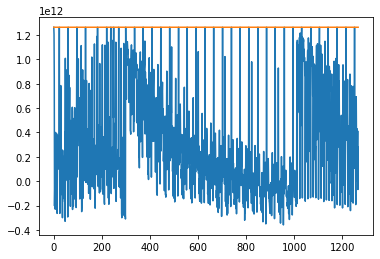

In [612]:
"""
load reductions calculated using the costcurvecooker

input: csv of all reductions (prepared using organize_azure_output.py)
        and definded ctax paths 
        
output: pandas dataframe with ctax paths and reductions until given year
"""

reload(prepare_paths)

# load reduction from azure output
emissions = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/co2tax_total.csv')
years = [1971, 1981, 1991, 2001, 2011, 2021, 2031, 2041, 2051, 2061, 2071, 2081, 2091, 2100]
columns = ['ctax_index', 'region'] + years  # dont know how to set headers for multi-index
emissions.columns = columns
emissions.region = emissions.region + 1

year_world = 2061

# baseline = emissions.loc[emissions.ctax_index == 0]
world_baseline = emissions.loc[emissions.ctax_index == 0][year_world].sum()

# load ctax paths csv
ctax_paths = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/IAMC_paths/all_ctax_paths.xlsx', index_col=[0])
ctax_paths.index.name = 'ctax_index'

# functie met jaar en regio geeft dataframe met paths en reducties (%)
data_for_emulator = prepare_paths.combine_azure_ctax(year, region, ctax_paths, emissions, baseline)
data_for_emulator_world = prepare_paths.world_emulator_data(year_world, ctax_paths, emissions, world_baseline)

print(data_for_emulator_world)

# prepare_paths.plot_MAC(data_for_emulator)

In [6]:
"""
prepare data using prepare_df

input: MAC sets (df)

output: ctax paths with reduction
"""
reload(prepare_CCL)

lin_reduction = prepare_CCL.reduction_df(df_linear, year, region)
cubic_reduction = prepare_CCL.reduction_df(df_cubic, year, region)
root_reduction = prepare_CCL.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_CCL.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_CCL.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_CCL.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

print(combi.year)

combi.tail()

2060


,2020,2030,2040,2050,2060,reduction
196,0.0,2469.445258,3111.306062,3561.556362,3920.0,95.4218
197,0.0,2482.044468,3127.180072,3579.727568,3940.0,95.4228
198,0.0,2494.643679,3143.054083,3597.898774,3960.0,95.4238
199,0.0,2507.242889,3158.928093,3616.069980,3980.0,95.4248
200,0.0,2519.842100,3174.802104,3634.241186,4000.0,95.4258


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v5.py:88: RuntimeWarning: divide by zero encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v5.py:88: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Anaconda3\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


weights dataframe: 
             0          1  ctax
0    0.000000   0.000000     0
1    0.000000   0.000000   200
2   -9.238005 -14.700565   400
3  -12.104221 -13.061063   600
4   -6.068916 -10.010753   800
5   -7.517914  -3.643026  1000
6  -12.224469 -17.838785  1200
7   -6.146602  -3.444374  1400
8   -4.277548  -8.133175  1600
9   -0.797664  -2.882918  1800
10  -2.110352  -8.049288  2000
11   9.395483 -40.366342  2200
12  -0.363015 -34.177480  2400
13  -3.613917 -24.812677  2600
14   5.544698 -21.701255  2800
15   3.328321 -12.274184  3000
16 -28.799059  74.051297  3200
17 -17.995849  41.835323  3400
18   7.884174 -25.075674  3600
19  22.068084 -75.667947  3800
20   2.865404  -3.302397  4000


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v5.py:184: RuntimeWarning: divide by zero encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v5.py:184: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v5.py:197: RuntimeWarning: invalid value encountered in matmul
  test_red = [self.y_test[i] - (delta_c_slice[i] @ b[i]) for i in range(len(self.y_test))]


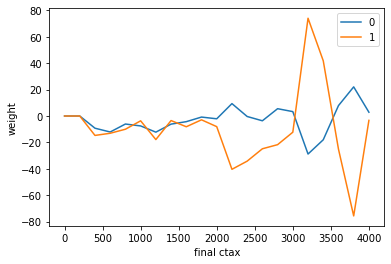

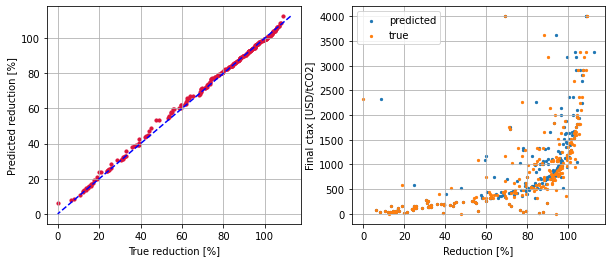

In [613]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

# x = emulate.CtaxRedEmulator(year, region, lin_paths, combi, test_size)

x = emulate.CtaxRedEmulator(year, region, data_for_emulator_world[0:109], data_for_emulator_world, test_size)

x.train_ctax_path(stepsize_ctax_paths, number_of_weights)   
    
pred = x.test_ctax_paths()
x.scatter_and_mac(pred)



247
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.7s finished


best params:  {'max_features': 'log2', 'n_estimators': 300}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.2s finished


best params:  {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}


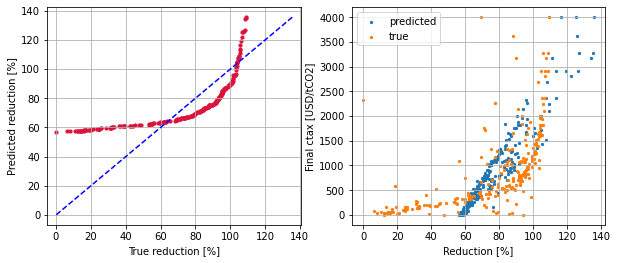

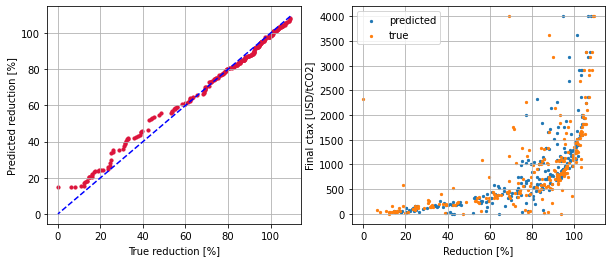

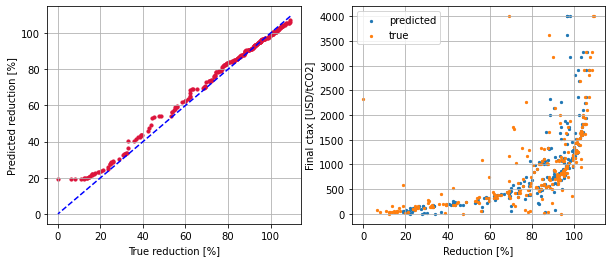

In [615]:
reload(emulate)

x = emulate.CtaxRedEmulator(year, region, lin_paths, data_for_emulator_world, test_size)

# multi linear regression model
multi_lin_regr_mod = x.train_ctax_MLR()
print(len(multi_lin_regr_mod))
# multi_lin_plot = x.test_regr(multi_lin_regr_mod)
x.scatter_and_mac(multi_lin_regr_mod)

# polynomial regression model
# degree = 3
# poly_regr_mod = x.train_ctax_PR(degree)
# poly_regr_plot = x.test_regr(poly_regr_mod)

# # Ridge regression
# alpha = 1
# ridge_mod = x.train_ctax_ridge(alpha)
# ridge_plot = x.test_regr(ridge_mod)

# # lasso regression
# alpha = 1
# lasso_mod = x.train_ctax_lasso(alpha)
# lasso_plot = x.test_regr(lasso_mod)

# Regression tree
max_depth = 5
# regr_tree = x.train_ctax_tree(max_depth)
# tree_plot = x.test_regr(regr_tree)

# Random forest
regr_forest = x.train_ctax_forest(max_depth)
# forest_plot = x.test_regr(regr_forest)
x.scatter_and_mac(regr_forest)

# SVM
svm_regr = x.train_SVM()
# svm_plot = x.test_regr(svm_regr)
x.scatter_and_mac(svm_regr)

# # MLPRegressor
# MLP_regr = x.train_MLPRegressor()
# MLP_plot = x.test_regr(MLP_regr)

# TensorFlow
# TF_regr = x.train_TF()


1263032000000.0


,region,ctax_index,1971,1981,1991,2001,2011,2021,2031,2041,2051,2061,2071,2081,2091,2100
0,1,0,8.969030e+10,1.117960e+11,1.169163e+11,1.406543e+11,1.487516e+11,1.577254e+11,1.564376e+11,1.496844e+11,1.536143e+11,1.411263e+11,1.459626e+11,1.584969e+11,1.367588e+11,1.192841e+11
1,2,0,1.110139e+12,1.245669e+12,1.299780e+12,1.512515e+12,1.474906e+12,1.395895e+12,1.345834e+12,1.350751e+12,1.349900e+12,1.162343e+12,1.081553e+12,1.027938e+12,9.156419e+11,8.441872e+11
2,3,0,3.019588e+10,6.728479e+10,8.076364e+10,1.000094e+11,1.319134e+11,1.435511e+11,1.534017e+11,1.534467e+11,1.620830e+11,1.694773e+11,1.819841e+11,2.092976e+11,1.786412e+11,1.634706e+11
3,4,0,2.121353e+10,2.690361e+10,2.661901e+10,3.867272e+10,4.919659e+10,5.919332e+10,7.899564e+10,1.014549e+11,1.167633e+11,1.318694e+11,1.619545e+11,1.960358e+11,1.838207e+11,1.764025e+11
4,5,0,2.441268e+10,5.178711e+10,6.683297e+10,9.672262e+10,1.356199e+11,1.484881e+11,1.507030e+11,1.502721e+11,1.356940e+11,1.318862e+11,1.561332e+11,1.684530e+11,1.338708e+11,1.120747e+11


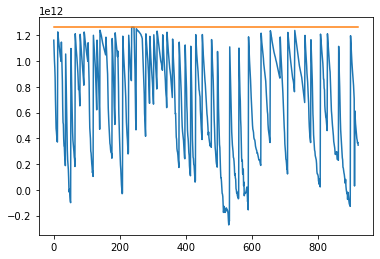

In [94]:
"""
emulate miti costs and compare to TIMER == TRUE 
"""
reload(emulate)
reload(prepare_paths)

# load TIMER miticosts set
miti_timer = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/random_scaled_mym/co2tax.csv', index_col=0)
columns = ['region', 'ctax_index'] + years
miti_timer.columns = columns
ctax_paths_miti = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/random_scaled_mym/scaled_random.xlsx', index_col=[0])
ctax_paths_miti.index.name = 'ctax_index' 
compare_miti = prepare_paths.combine_azure_ctax(year, region, ctax_paths_miti, miti_timer, baseline)

emu_method = 'SVM'
step_ctax = 40
# x.calc_miti_costs(emu_method, region, step_ctax, miti_timer, baseline, compare_miti)

miti_timer.head()


     2020  2030        2040        2050        2060  emu reduction
131   0.0   0.0   17.277042   25.651393   33.764623      11.760188
132   0.0   0.0   34.554084   51.302786   67.529247      17.188342
133   0.0   0.0   51.831127   76.954179  101.293870      23.738832
134   0.0   0.0   69.108169  102.605572  135.058493      30.901898
135   0.0   0.0   86.385211  128.256965  168.823117      38.255612
136   0.0   0.0  103.662253  153.908357  202.587740      45.442560
137   0.0   0.0  120.939296  179.559750  236.352363      52.138057
138   0.0   0.0  138.216338  205.211143  270.116987      58.047072
139   0.0   0.0  155.493380  230.862536  303.881610      62.942082 
      2020  2030        2040        2050        2060  reduction
131   0.0   0.0   17.277042   25.651393   33.764623   7.932816
132   0.0   0.0   34.554084   51.302786   67.529247  13.965600
133   0.0   0.0   51.831127   76.954179  101.293870  19.480504
134   0.0   0.0   69.108169  102.605572  135.058493  24.552854
135   0.0   0

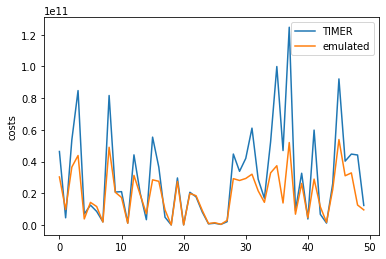

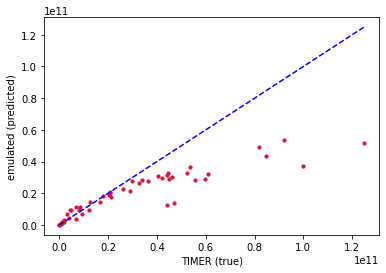

In [97]:
# all seperate scaled random df's
x.calc_miti_timer(ctax_paths_miti, compare_miti, baseline)
x.calc_miti_emu(ctax_paths_miti, compare_miti, baseline)
x.plot_timer_vs_emu()